In [15]:
import time
import numpy as np 
from pandas import Series, DataFrame
import pandas as pd
import seaborn as sns
import copy
from astropy import table
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from catboost import CatBoostRegressor

##### Import data

In [16]:
data = pd.read_parquet(r'D:\Estágio IA\newdata\data.parquet')
target = pd.read_parquet(r'D:\Estágio IA\newdata\target_easy.parquet')

## MultiOutputRegressor

In [3]:
labels = ['ez_z_phot','ez_mass','ez_sfr']
columns_df = ['catboost']

X = data
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

models = [
    CatBoostRegressor(
        n_estimators = 100,
        max_depth = 8,
        verbose=0
    )
]

pred_dict = {}

for i, method in enumerate(models):
    model_name = columns_df[i]
    print(f"\nTraining {model_name}...")
    
    start_time = time.time()
    
    regressor = MultiOutputRegressor(method)
    regressor.fit(X_train, y_train)
    pred = regressor.predict(X_val)

    end_time = time.time()
    execution_time = end_time - start_time
    
    print(f"Execution time for {model_name}: {execution_time:.2f} seconds")

    for j, label in enumerate(labels):
        col_name = model_name + '_' + label
        pred_dict[col_name] = pred[:, j]

pred_df = pd.DataFrame(pred_dict, index=y_val.index)


Training catboost...
Execution time for catboost: 52.16 seconds


In [4]:
pred_df

,catboost_ez_z_phot,catboost_ez_mass,catboost_ez_sfr
309685,1.990146,9.383637,0.490752
588959,3.450932,2.441729,-0.653206
389493,3.243420,8.916492,-0.503253
394871,1.345811,8.042322,-0.293117
296031,2.285302,8.466798,-0.250256
...,...,...,...
316350,8.427308,0.321407,0.769404
412373,3.291732,9.681485,1.346093
225354,0.721726,6.977055,-1.754642
688732,3.944353,7.412645,-0.675005


In [5]:
def metric_redshift(x,y):
    met = np.abs(pd.Series(y-x))
    f_out = met/(1+x.astype(np.float32))
    nmad=1.48*np.median(f_out)
    bias = np.median(f_out)
    y_outlier = pd.Series(np.where(f_out > 0.15, 'outlier', 'not outlier'))
    print("{}\n".format(y_outlier.value_counts()))
    print("Bias: {:.2f}\n".format(bias))
    print("NMAD score: {:.2f}\n".format(nmad))
    print('r2= {:.2f}'.format(r2_score(x, y)))
    pass

In [6]:
def metrics(x, y):
    f_out = np.abs(pd.Series(y-x))
    nmad=1.48 * np.median(f_out)
    bias = np.median(f_out)
    y_outlier = pd.Series(np.where(f_out > 0.3, 'outlier', 'not outlier'))
    print("{}\n".format(y_outlier.value_counts()))
    print("Bias: {:.2f}\n".format(bias))
    print("NMAD score: {:.2f}\n".format(nmad))
    print('r2= {:.2f}'.format(r2_score(x, y)))
    pass

--------ez_z_phot--------
outlier        66505
not outlier    54040
dtype: int64

Bias: 0.18

NMAD score: 0.26

r2= 0.52
--------ez_mass--------
outlier        70669
not outlier    49876
dtype: int64

Bias: 0.42

NMAD score: 0.62

r2= 0.63
--------ez_sfr--------
outlier        76839
not outlier    43706
dtype: int64

Bias: 0.46

NMAD score: 0.68

r2= 0.53


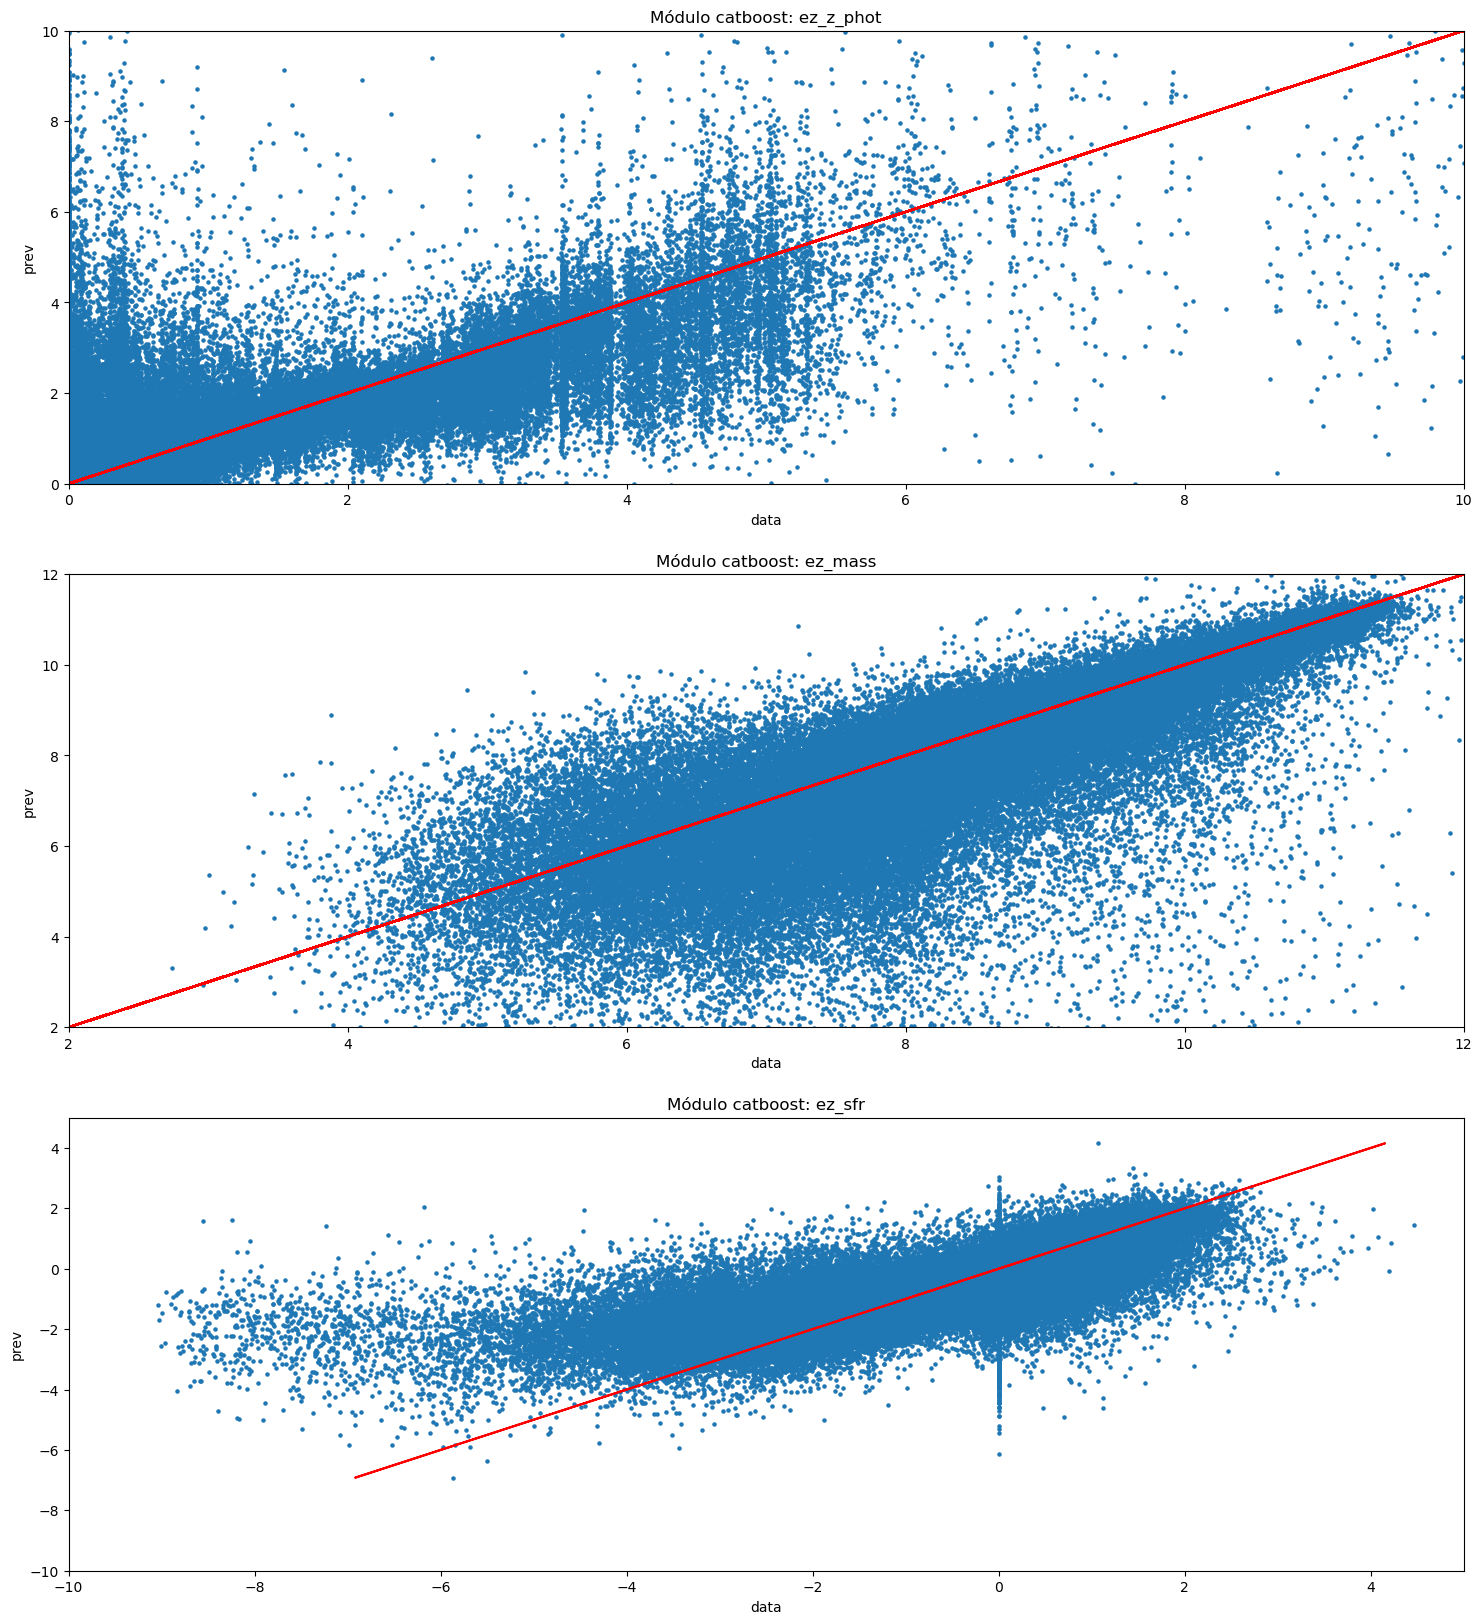

In [20]:
fig, axes = plt.subplots(nrows=len(labels), ncols=1, figsize=(18, 20))

marker_size = 5

x_limits = {
    'ez_z_phot': (0, 10),
    'ez_sfr': (-10, 5),
    'ez_mass' : (2, 12),
}

y_limits = x_limits


for i, label in enumerate(labels):
    # catboost
    x = y_val[label]
    y = pred_df['catboost_' + label]
    axes[i].scatter(x, y, s=marker_size)
    axes[i].plot(y, y, color='red') 
    axes[i].set_xlabel('data')
    axes[i].set_ylabel('prev')
    axes[i].set_title('Módulo catboost: {}'.format(label))
    
    if label == 'ez_z_phot':
        print('--------{}--------'.format(label),end ='\n')
        metric_redshift(x,y)
    else:
        print('--------{}--------'.format(label),end ='\n')
        metrics(x,y)
    
    axes[i].set_xlim(x_limits[label])
    axes[i].set_ylim(y_limits[label])
#plt.savefig('ML.png')    
plt.show()

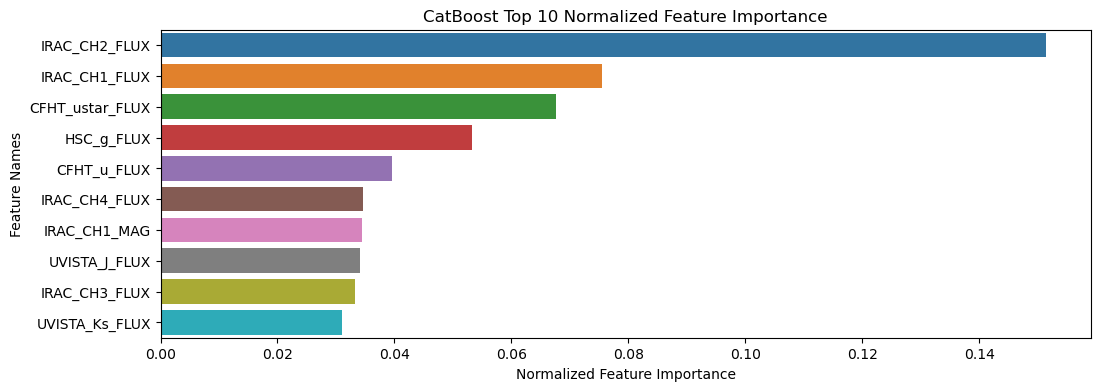

In [8]:
def plot_feature_importance(importance, names, model_type):

    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # Normalize feature importance values
    normalized_importance = feature_importance / feature_importance.sum()

    # Create a DataFrame using a Dictionary
    data = {'feature_names': feature_names, 'feature_importance': normalized_importance}
    fi_df = pd.DataFrame(data)

    # Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    # Select only the top 10 features
    top_10_features = fi_df.head(10)

    # Define size of bar plot
    plt.figure(figsize=(12, 4))
    # Plot Seaborn bar chart
    sns.barplot(x=top_10_features['feature_importance'], y=top_10_features['feature_names'])
    # Add chart labels
    plt.title(model_type + ' Top 10 Normalized Feature Importance')
    plt.xlabel('Normalized Feature Importance')
    plt.ylabel('Feature Names')
    plt.savefig('features_importances.png')

features_importances = regressor.estimators_[0].feature_importances_
names = X_train.columns
model_type = 'CatBoost'


plot_feature_importance(features_importances, names, model_type)


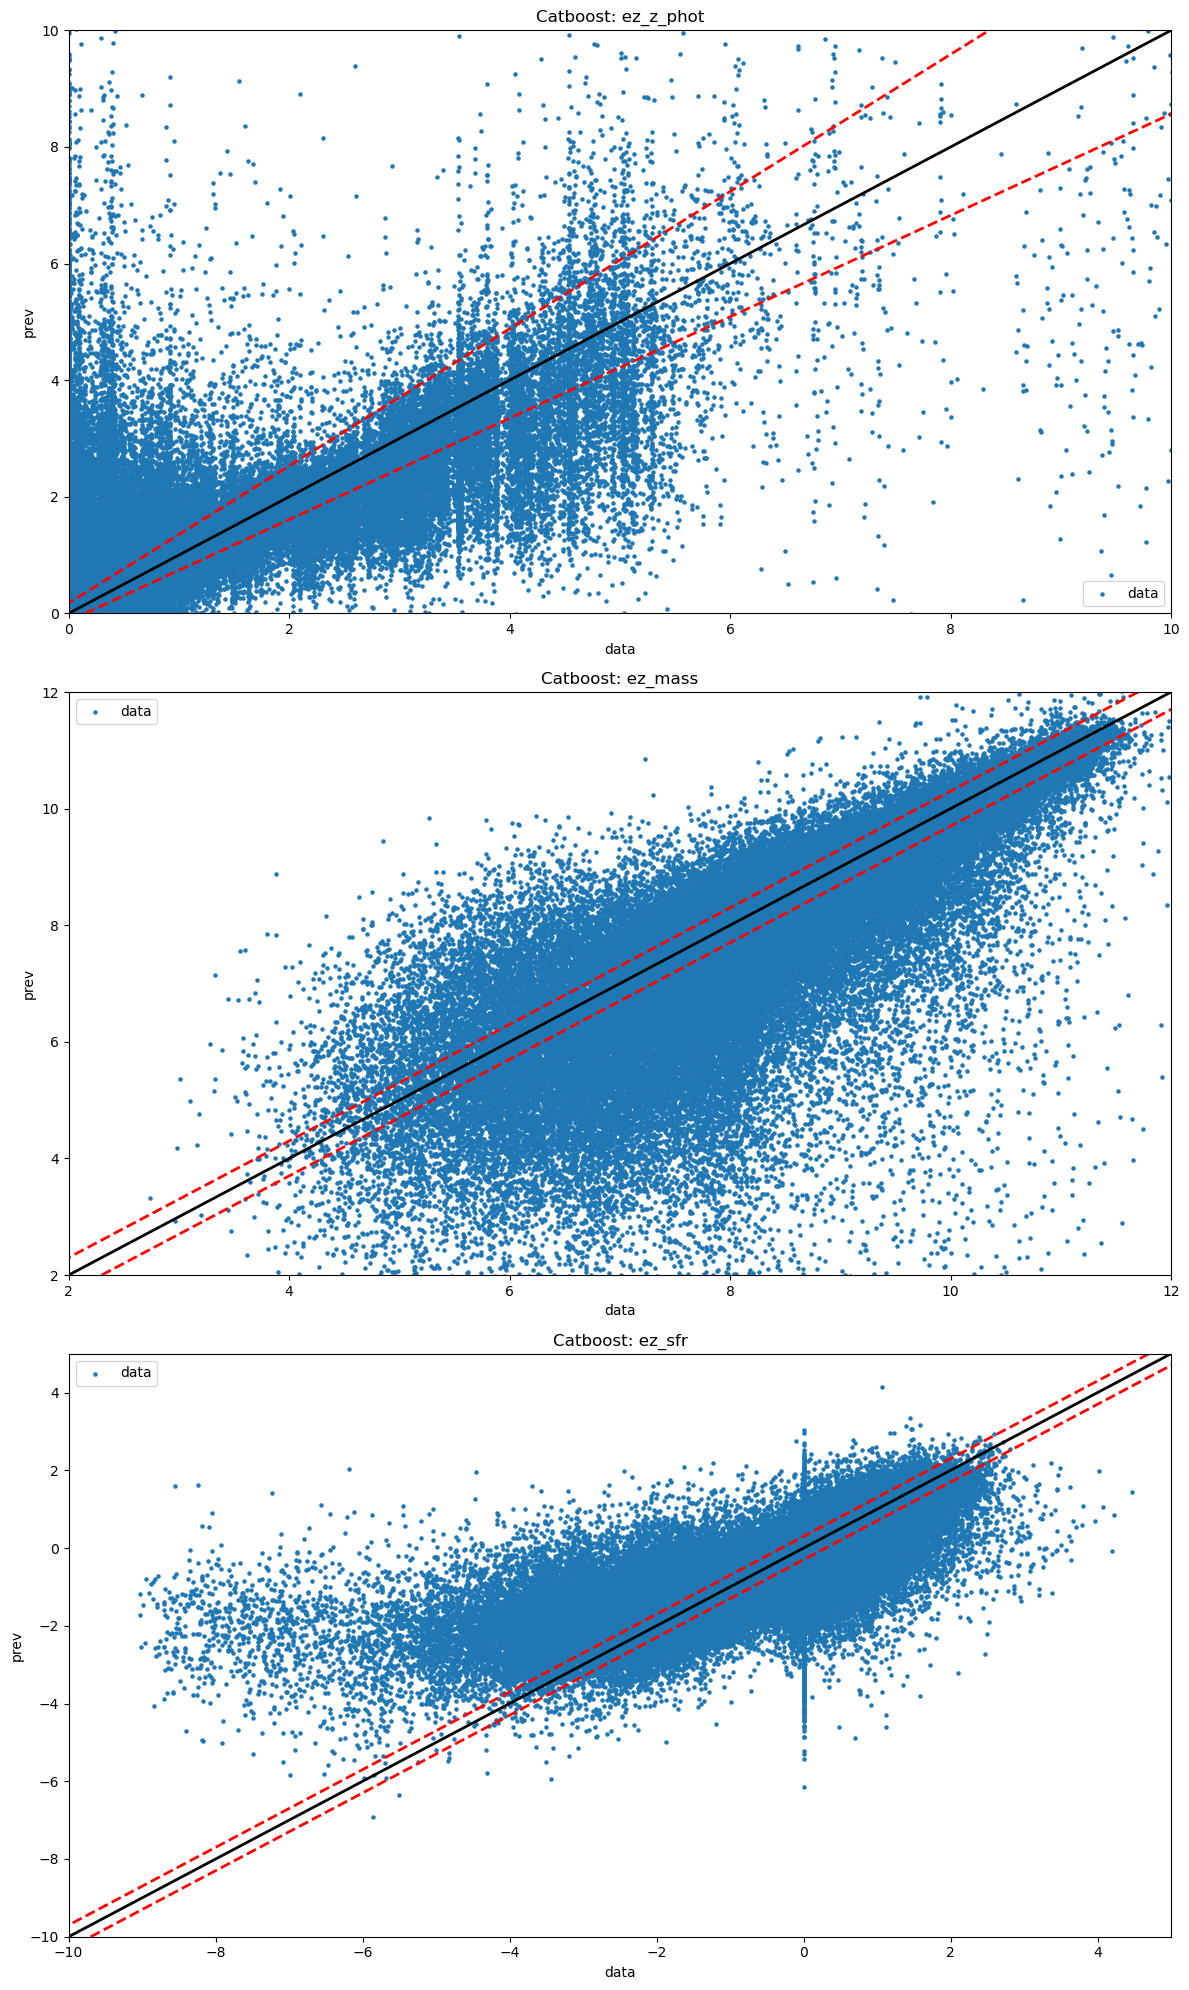

In [9]:
x_limits = {
    'ez_z_phot': (0, 10),
    'ez_sfr': (-10, 5),
    'ez_mass' : (2, 12),
}

y_limits = x_limits

labels = ['ez_z_phot','ez_mass','ez_sfr']

marker_size = 5
fig, axes = plt.subplots(nrows=len(labels), ncols=1, figsize=(12, 20))

outliers = {}
for i,label in enumerate(labels):
    
    ref = y_val[label]
    phot = pred_df['catboost_' + label]

    if label == 'ez_z_phot':
        f_out = np.abs((phot - ref) / (1 + ref))
        threshold = 0.15
        axes[i].plot([x_limits[label][0]-threshold*(1+x_limits[label][0]),x_limits[label][1]-threshold*(1+x_limits[label][1])],[x_limits[label][0],x_limits[label][1]], color = 'red', linestyle='dashed',linewidth = 2)
        axes[i].plot([x_limits[label][0]+threshold*(1+x_limits[label][0]),x_limits[label][1]+threshold*(1+x_limits[label][1])],[x_limits[label][0],x_limits[label][1]], color = 'red', linestyle='dashed',linewidth = 2)
        axes[i].plot([y_limits[label][0],y_limits[label][1]],[y_limits[label][0],y_limits[label][1]], color = 'black',linewidth = 2)
    else:
        f_out = np.abs(phot - ref)
        threshold = 0.30
        axes[i].plot([-threshold+y_limits[label][0],-threshold+y_limits[label][1]],[y_limits[label][0],y_limits[label][1]], color = 'red', linestyle='dashed',linewidth = 2)
        axes[i].plot([+threshold+y_limits[label][0],+threshold+y_limits[label][1]],[y_limits[label][0],y_limits[label][1]], color = 'red', linestyle='dashed',linewidth = 2)
        axes[i].plot([y_limits[label][0],y_limits[label][1]],[y_limits[label][0],y_limits[label][1]], color = 'black',linewidth = 2)

    axes[i].scatter(ref, phot, s=marker_size, label='data')
    axes[i].set_xlabel('data')
    axes[i].set_ylabel('prev')
    axes[i].set_title(f'Catboost: {label}')
    axes[i].legend()
    axes[i].set_xlim(y_limits[label])
    axes[i].set_ylim(x_limits[label])


plt.tight_layout()
plt.show()

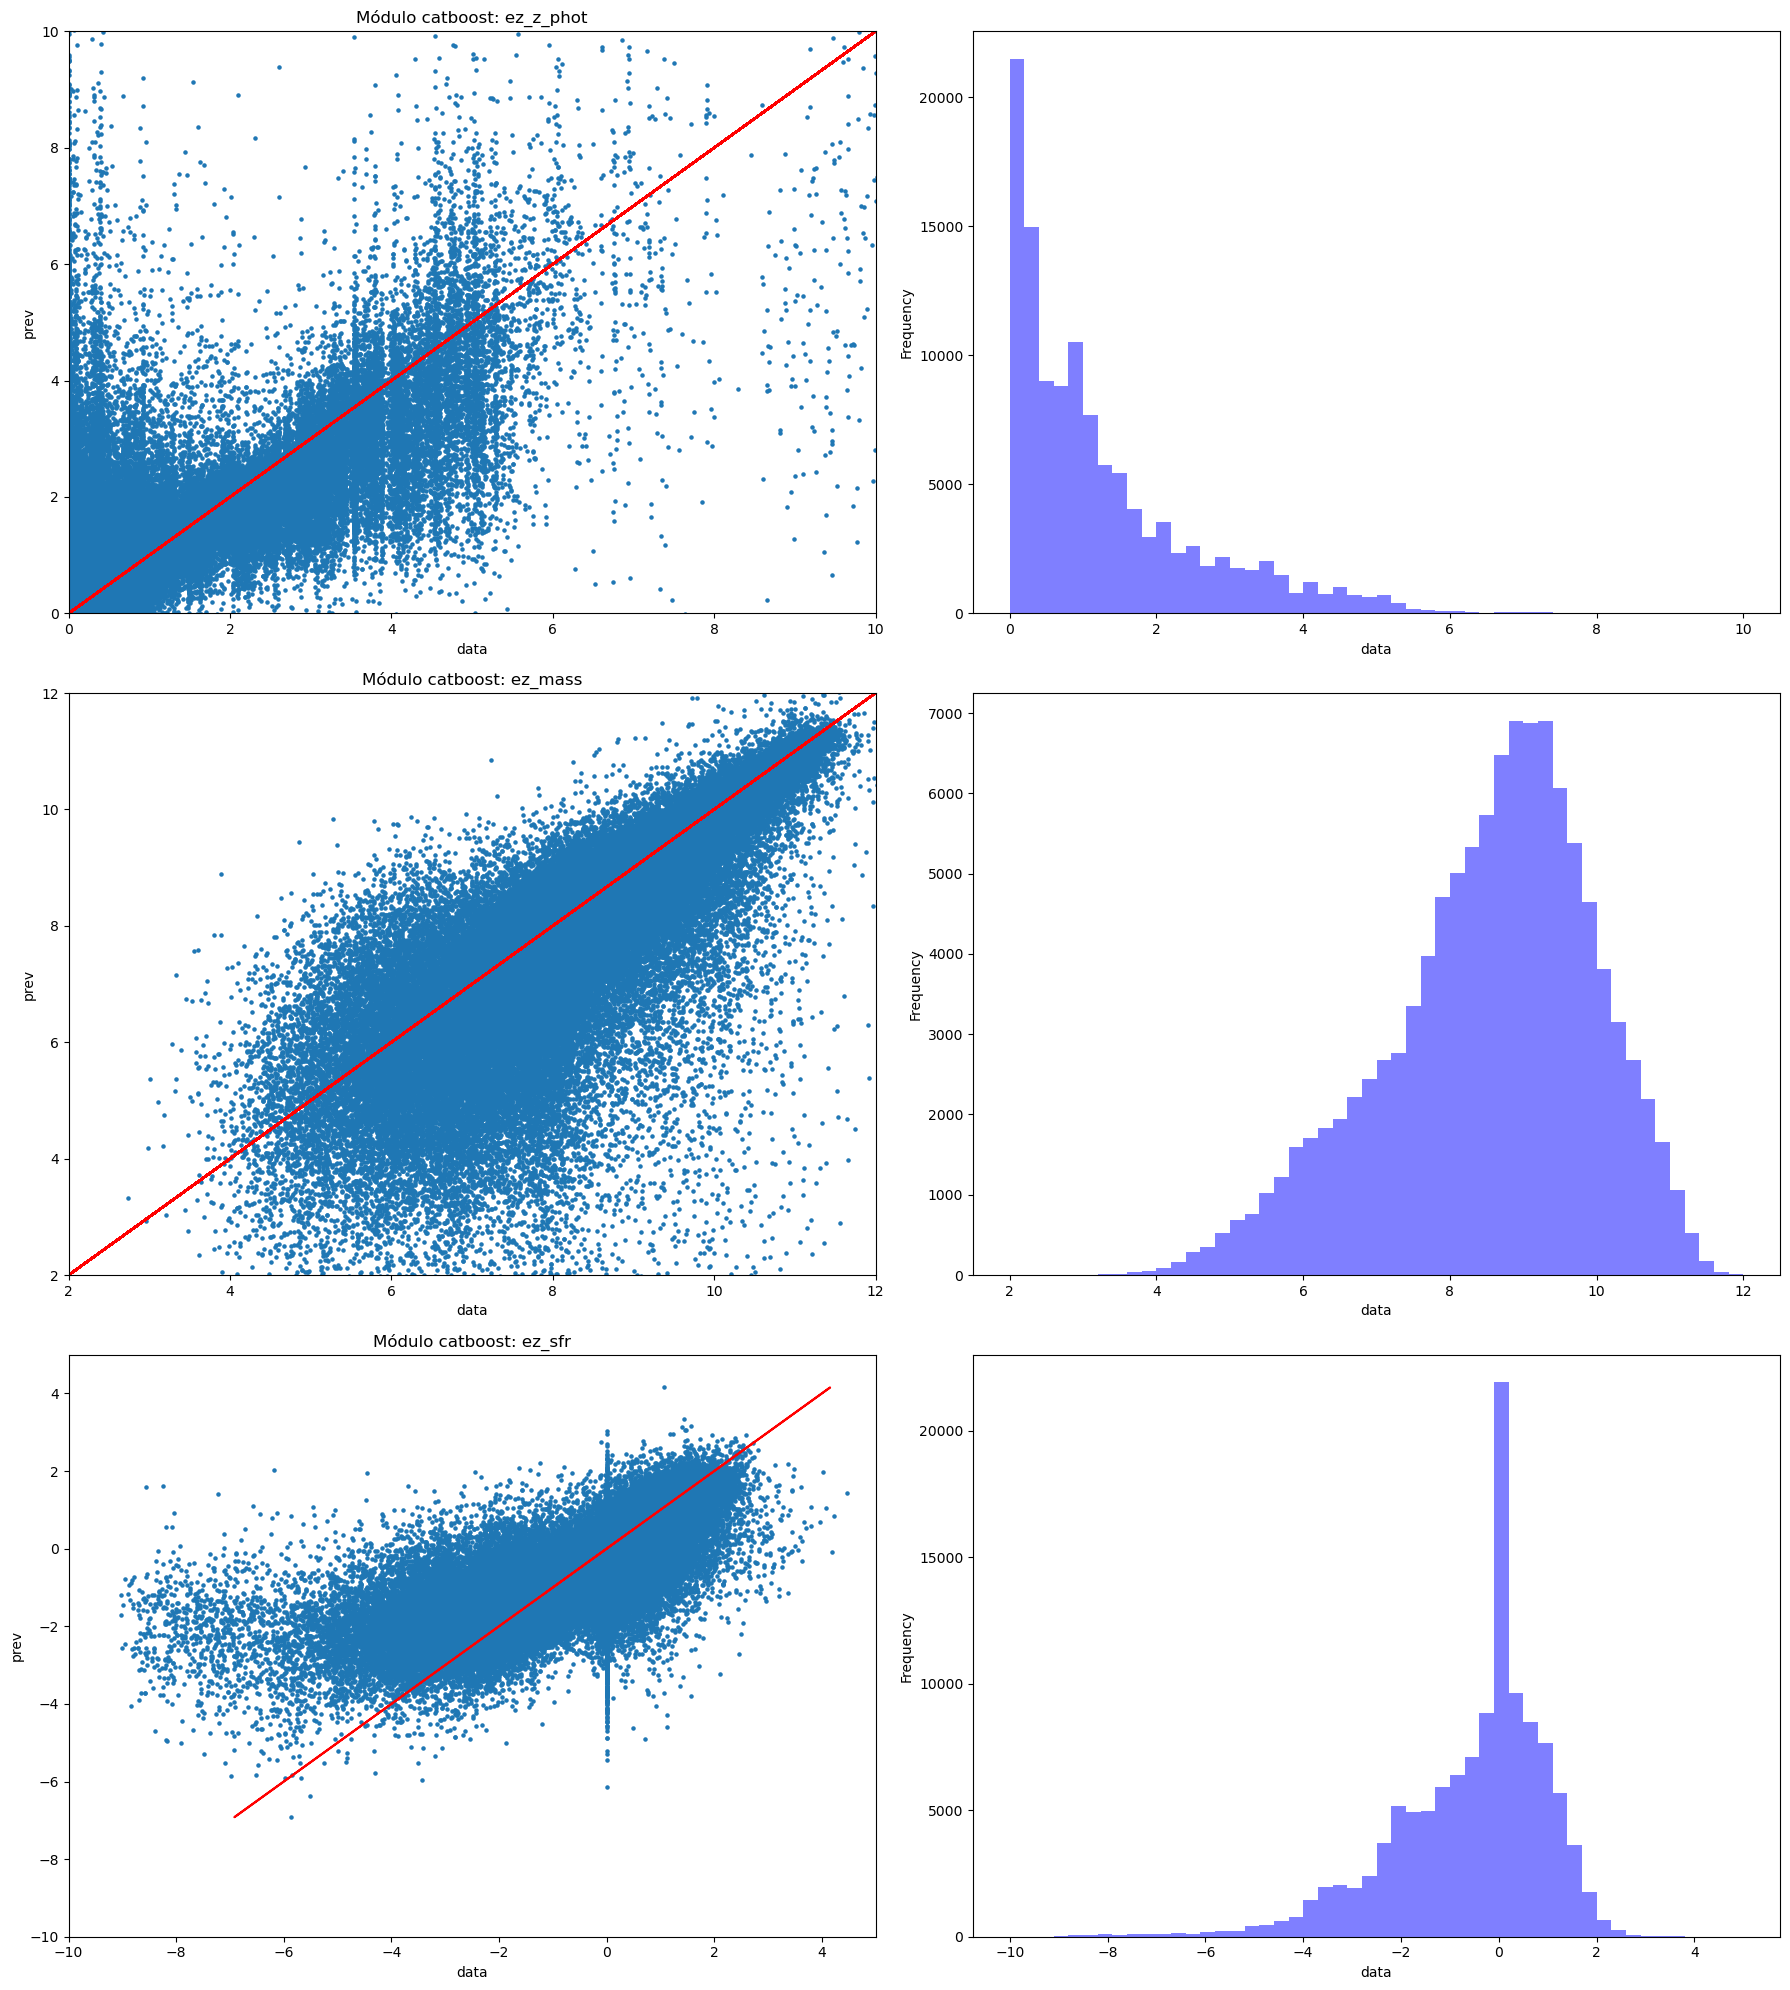

In [23]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=len(labels), ncols=2, figsize=(18, 20))
marker_size = 5

x_limits = {
    'ez_z_phot': (0, 10),
    'ez_sfr': (-10, 5),
    'ez_mass': (2, 12),
}

y_limits = x_limits

for i, label in enumerate(labels):
    # catboost
    x = y_val[label]
    y = pred_df['catboost_' + label]

    # Scatter plot
    axes[i, 0].scatter(x, y, s=marker_size)
    axes[i, 0].plot(y, y, color='red')
    axes[i, 0].set_xlabel('data')
    axes[i, 0].set_ylabel('prev')
    axes[i, 0].set_title('Módulo catboost: {}'.format(label))
    axes[i, 0].set_xlim(x_limits[label])
    axes[i, 0].set_ylim(y_limits[label])

    # Histogram for x
    axes[i, 1].hist(x, bins=50, range=x_limits[label], color='blue', alpha=0.5)
    axes[i, 1].set_xlabel('data')
    axes[i, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()
